In [31]:
from ultralytics import SAM
import torch
from matplotlib import pyplot as plt
import cv2 
import numpy as np

from transformers import GPT2Tokenizer
from transformers import Owlv2Processor, Owlv2ForObjectDetection

from torchvision.datasets import CocoCaptions

# from clip_text_decoder.model import DecoderInferenceModel
from model import DecoderInferenceModel
import spacy

from PIL import Image


device = 'cuda' if torch.cuda.is_available() else 'cpu'


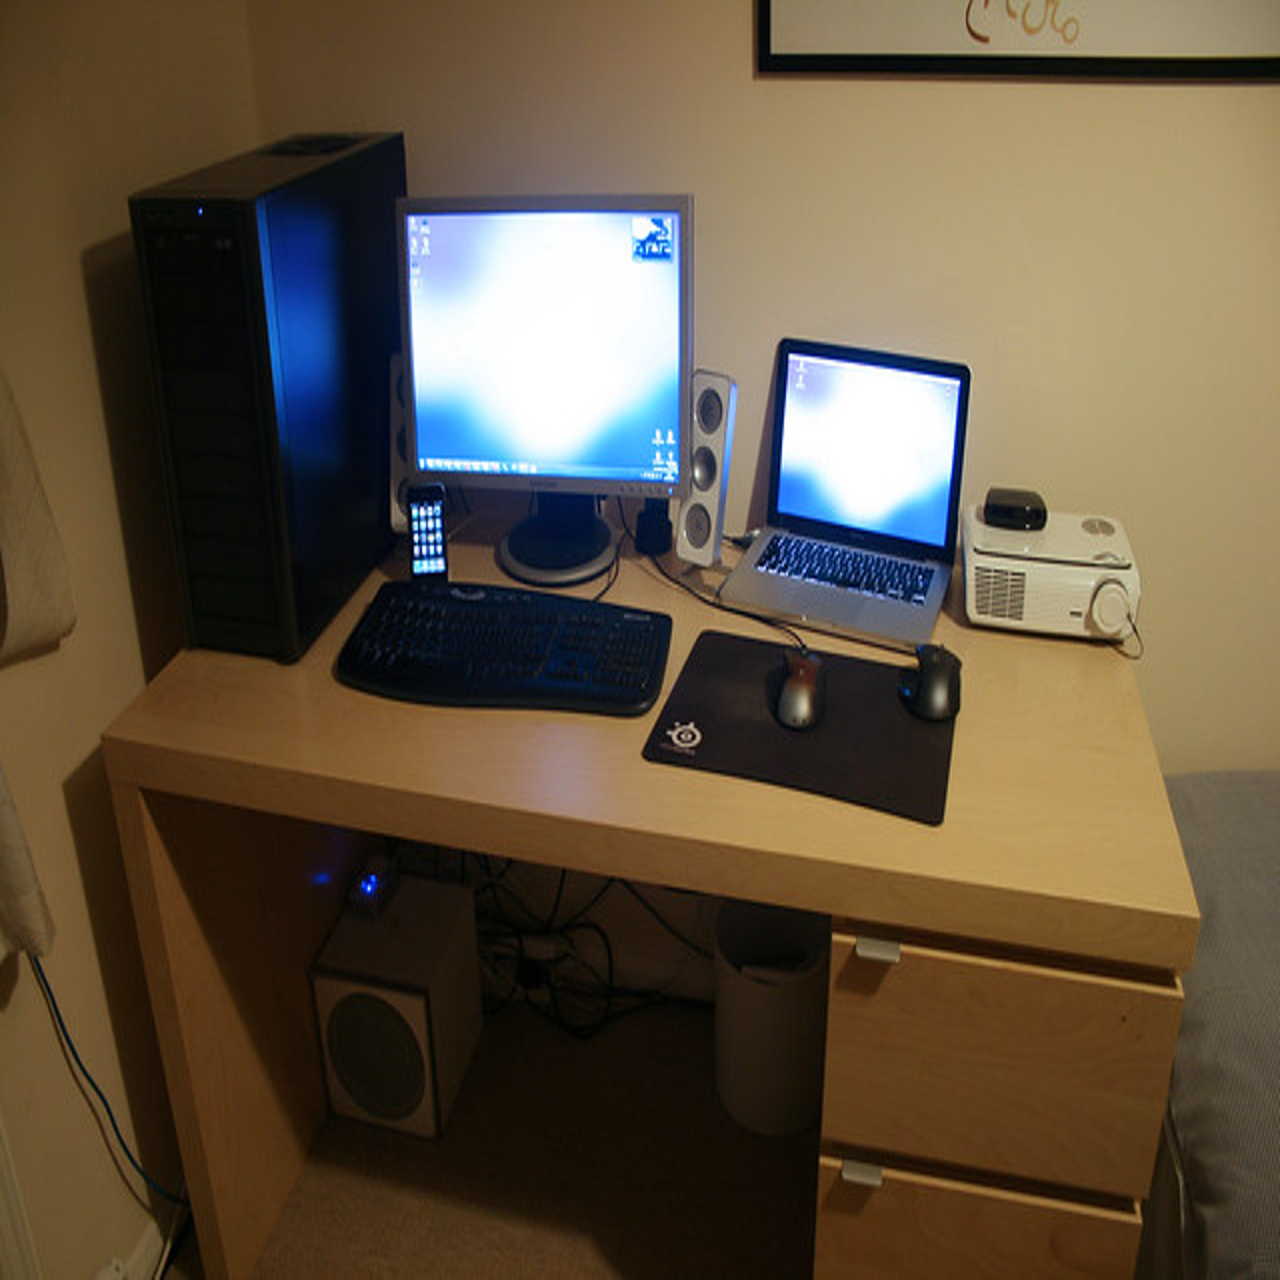

In [69]:
import requests

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# url = 'http://farm9.staticflickr.com/8437/7910770924_e51c726cc7_z.jpg'
# url = "http://farm5.staticflickr.com/4055/4590650151_c410906e50_z.jpg"
# url = "http://farm8.staticflickr.com/7154/6506781427_965a5f2bc6_z.jpg"
# url = "http://farm3.staticflickr.com/2220/2218961434_7916358f53_z.jpg"
url = "http://farm4.staticflickr.com/3468/3985002426_7ac078228e_z.jpg"
img = Image.open(requests.get(url, stream=True).raw)
img = img.resize((1280, 1280))

img

In [33]:
class DetectEverything:
    def __init__(self, decoder_weights: str, device: str):
        self.device = device

        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

        self.processor_owl = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
        self.model_owl = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")
        self.model_owl.to(self.device)
        self.model_owl.eval()

        self.model_gpt = DecoderInferenceModel.load(decoder_weights).to(device)

        self.nlp = spacy.load('en_core_web_md')

    def get_image_features(self, image: Image.Image, objectness_threshold=0.2):
        inputs = self.processor_owl(text=[[""]], images=image, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.model_owl(**inputs)

        image_embeddings = outputs.image_embeds.reshape(1, -1, 768)
        obejectness = torch.sigmoid(outputs.objectness_logits) > objectness_threshold
        indices = torch.where(obejectness)[1]

        boxes = outputs.pred_boxes[0][indices]
        image_embeddings = image_embeddings[:, indices, :]

        return image_embeddings, boxes
    
    
    def get_captions(self, image_embeddings):
        all_captions = []

        for i in range(image_embeddings.shape[1]):
            with torch.no_grad():
                # outputs = inference_model(x = image_embeddings[:, i, :].unsqueeze(1), max_len=100, beam_size=3, input_text="Objects list:")
                outputs = self.model_gpt(x = image_embeddings[:, i, :].unsqueeze(1), max_len=100, beam_size=3, input_text=None)

                all_captions.append(outputs)

        return all_captions
    
    
    def extract_object_names(self, sentence):
        # Process the sentence
        doc = self.nlp(sentence)
        
        # Words to exclude specifically
        exclude_words = {"various", "several", "multiple", "many", "few", "some", "similar" 
                        , "bottom", "lower", "right", "left", "top", "upper", "center"}

        # Container for object names
        object_names = []

        # Iterate over tokens in the sentence
        for token in doc:
            # Skip unwanted words based on POS tags, dependency relations, and specific excludes
            if (token.pos_ in ['DET', 'ADP', 'NUM', 'AUX', 'PART'] or 
                token.dep_ in ['aux', 'prep', 'det', 'nummod'] or 
                token.text.lower() in exclude_words):
                continue

            # Append nouns, proper nouns, adjectives (if modifying a noun), or participles
            if token.pos_ in ['NOUN', 'PROPN'] or (token.dep_ in ['amod', 'compound', 'nsubj'] and token.head.pos_ in ['NOUN', 'PROPN']):
                # Check for compound nouns or noun-adjective combinations
                if token.dep_ == 'compound' or (token.dep_ == 'amod' and token.head.dep_ != 'ROOT'):
                    # Ensure the adjective is not in the exclude list
                    if token.text.lower() not in exclude_words:
                        object_name = f"{token.text} {token.head.text}"
                        object_names.append(object_name)
                else:
                    object_names.append(token.text)
        
        # Remove duplicates and reassemble object names considering adjacency
        object_names = list(set(object_names))
        
        # if objecy name is single word, change it to lemmatized form
        for i in range(len(object_names)):
            if len(object_names[i].split()) == 1:
                object_names[i] = self.nlp(object_names[i])[0].lemma_

        return object_names

    def get_all_object_names(self, all_captions):
        all_object_names = []

        for caption in all_captions:
            object_names = self.extract_object_names(caption)
            all_object_names.extend(object_names)

        all_object_names = list(set(all_object_names))

        return all_object_names        

    def owl_detection(self, image, object_names, threshold=0.25):
        inputs = self.processor_owl(text=[object_names], images=image, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.model_owl(**inputs)

        # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
        target_sizes = torch.Tensor([image.size[::-1]])
        # Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
        results = self.processor_owl.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=threshold)

        boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]
        boxes = boxes.cpu().numpy()
        scores = scores.cpu().numpy()
        labels = labels.cpu().numpy()

        return boxes, scores, labels
    
    def __call__(self, image: Image.Image, objectness_threshold=0.2, detection_threshold=0.25):
        width, height = image.size
        image = image.resize((1280, 1280))

        print("Getting image features")
        image_embeddings, boxes = self.get_image_features(image, objectness_threshold=objectness_threshold)

        print("Getting captions")
        all_captions = self.get_captions(image_embeddings)
        print(all_captions)

        print("Extracting object names")
        object_names = self.get_all_object_names(all_captions)
        print(object_names)

        print("Detecting objects")
        boxes, scores, labels = self.owl_detection(image, object_names, threshold=detection_threshold)

        labels = [object_names[i] for i in labels]

        for i in range(len(boxes)):
            box = boxes[i]

            x1, y1, x2, y2 = box
            x1 = int(x1 * width / 1280)
            y1 = int(y1 * height / 1280)
            x2 = int(x2 * width / 1280)
            y2 = int(y2 * height / 1280)

            boxes[i] = [x1, y1, x2, y2]

        return boxes, scores, labels
        

In [63]:
model = SAM('sam_l.pt').to(device)

detector = DetectEverything("clip-text-decoder/lightning_logs/version_14/model.pt", device)

100%|██████████| 1.16G/1.16G [02:24<00:00, 8.66MB/s]


Getting image features
Getting captions
['a computer monitor, a speaker, a computer keyboard, a computer mouse, and a section of jeans.', 'a room with two speakers as part of stereo equipment, one on the left and the other on the right. There are two speakers on the left and right sides of the image, with one speaker on the left and the other on the right. Additionally, there is a wall socket on the left side of the image.', 'a computer setup with two computer monitors, a computer keyboard, a computer mouse, and two chairs.', 'a room with two speakers, one on the left and one on the right, both placed symmetrically on a table. There are two speakers on the left and right sides of the image, with one speaker on the left and the other on the right. Additionally, there are two speakers on the left and right sides of the image.', 'two cellular telephones, one slightly to the left and the other to the right, with a computer keyboard below them. Additionally, there is a wall socket on the le

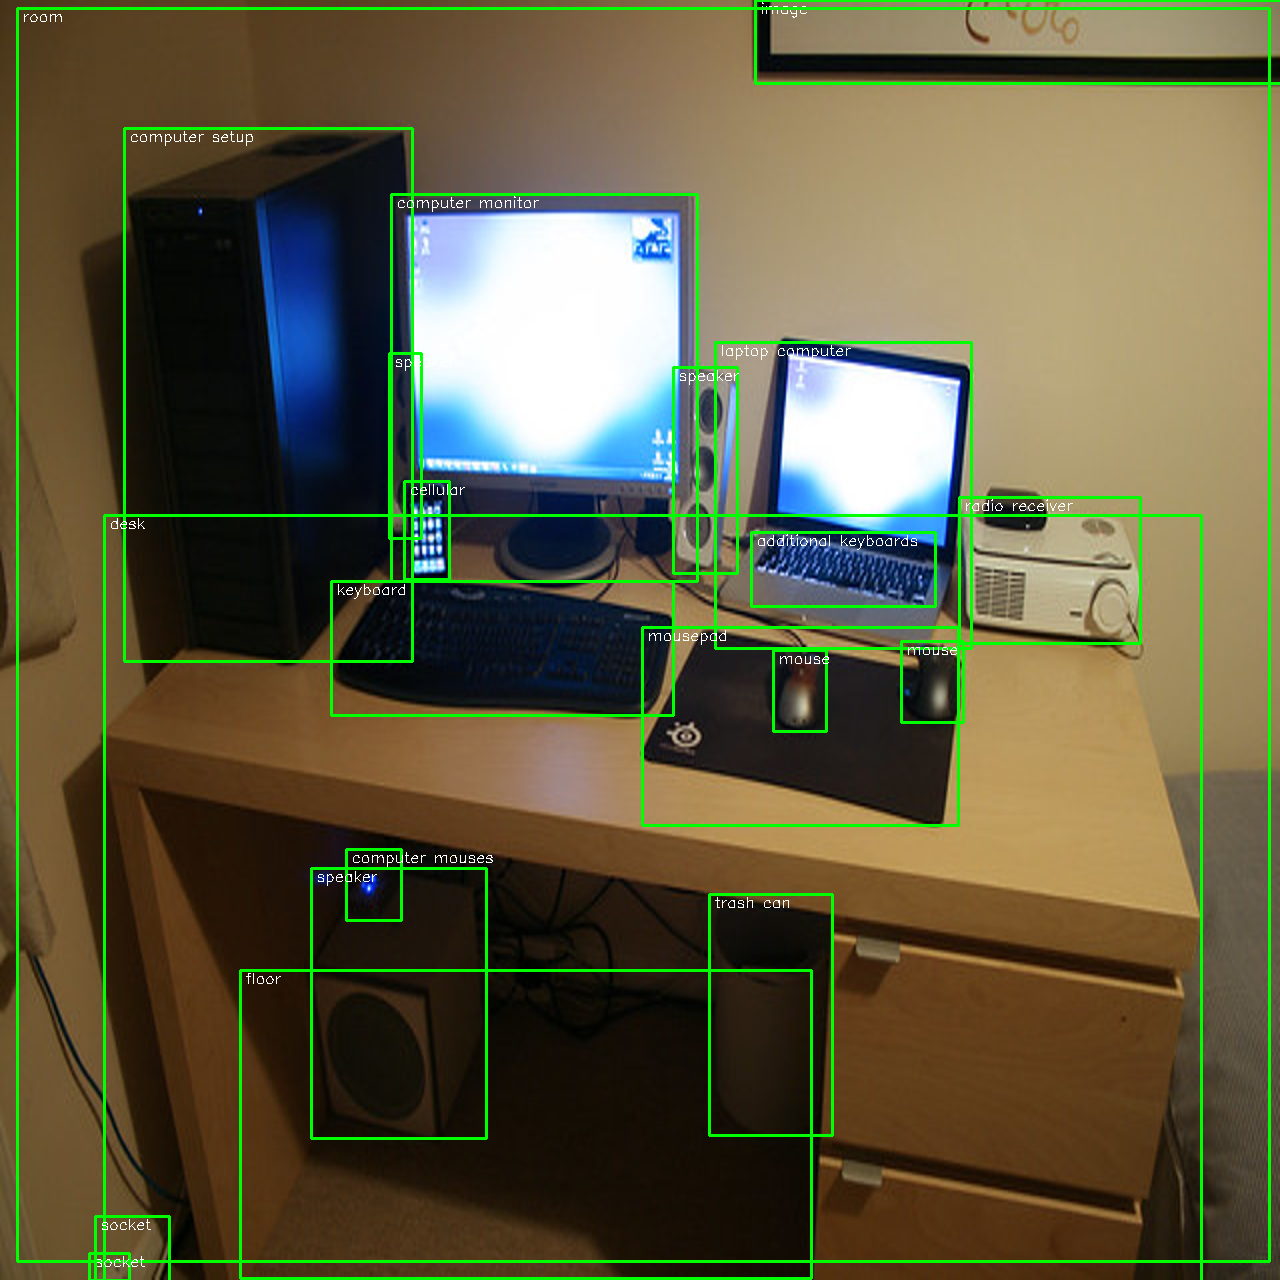

In [70]:
boxes, scores, labels = detector(img, objectness_threshold=0.25, detection_threshold=0.25)

image_result = np.array(img).copy()
height, width, _ = image_result.shape

for box, score, label in zip(boxes, scores, labels):
    box = [int(i) for i in box.tolist()]
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    cv2.rectangle(
        image_result, (x1, y1), (x2, y2), (0, 255, 0), 2
    )
    cv2.putText(
        image_result,
        label,
        (x1+5, y1 +13),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        1,
    )
    print(f"{label}: {score}")

Image.fromarray(image_result)

In [71]:
# Run inference with bboxes prompt
results = model(img, bboxes=boxes, save=False)


0: 1024x1024 454.6ms
Speed: 7.3ms preprocess, 454.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


(-0.5, 1279.5, 1279.5, -0.5)

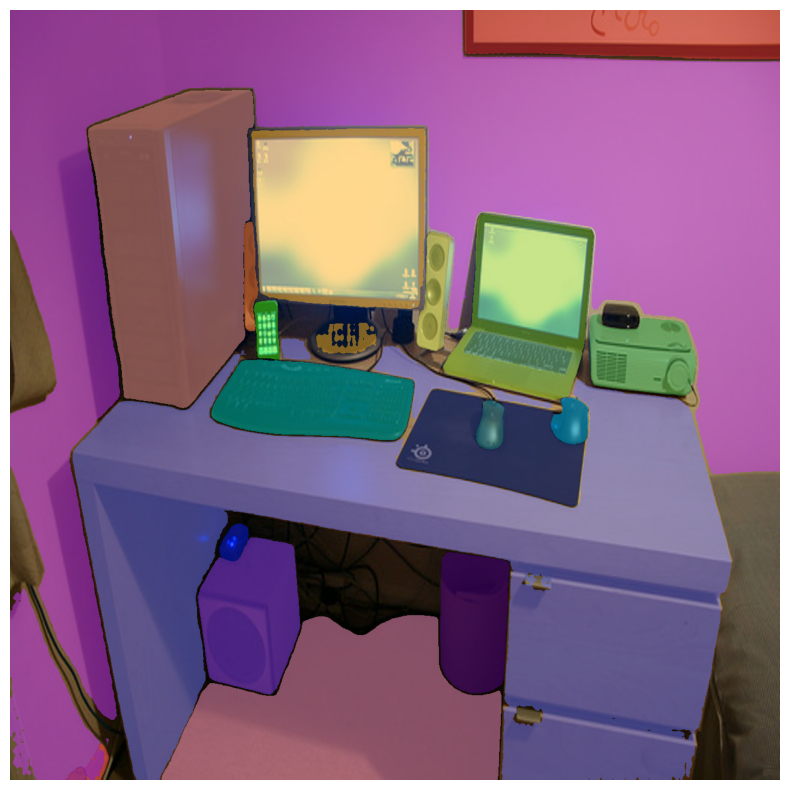

In [72]:
# draw mask on original image

img = results[0].orig_img
mask = results[0].masks

result_img = results[0].plot()
result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(result_img)
plt.axis('off')